# The Agent Loop: Building Production Agents with LangChain 1.0

In this notebook, we'll explore the foundational concepts of AI agents and learn how to build production-grade agents using LangChain's new `create_agent` abstraction with middleware support.

**Learning Objectives:**
- Understand what an "agent" is and how the agent loop works
- Learn the core constructs of LangChain (Runnables, LCEL)
- Master the `create_agent` function and middleware system
- Build an agentic RAG application using Qdrant

## Table of Contents:

- **Breakout Room #1:** Introduction to LangChain, LangSmith, and `create_agent`
  - Task 1: Dependencies
  - Task 2: Environment Variables
  - Task 3: LangChain Core Concepts (Runnables & LCEL)
  - Task 4: Understanding the Agent Loop
  - Task 5: Building Your First Agent with `create_agent()`
  - Question #1 & Question #2
  - Activity #1: Create a Custom Tool

- **Breakout Room #2:** Middleware - Agentic RAG with Qdrant
  - Task 6: Loading & Chunking Documents
  - Task 7: Setting up Qdrant Vector Database
  - Task 8: Creating a RAG Tool
  - Task 9: Introduction to Middleware
  - Task 10: Building Agentic RAG with Middleware
  - Question #3 & Question #4
  - Activity #2: Enhance the Agent

---
# 🤝 Breakout Room #1
## Introduction to LangChain, LangSmith, and `create_agent`

## Task 1: Dependencies

First, let's ensure we have all the required packages installed. We'll be using:

- **LangChain 1.0+**: The core framework with the new `create_agent` API
- **LangChain-OpenAI**: OpenAI model integrations
- **LangSmith**: Observability and tracing
- **Qdrant**: Vector database for RAG
- **tiktoken**: Token counting for text splitting

In [5]:
# Run this cell to install dependencies (if not using uv sync)
# !pip install langchain>=1.0.0 langchain-openai langsmith langgraph qdrant-client langchain-qdrant tiktoken nest-asyncio

In [1]:
# Core imports we'll use throughout the notebook
import os
import getpass
from uuid import uuid4

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

## Task 2: Environment Variables

We need to set up our API keys for:
1. **OpenAI** - For the GPT-5 model
2. **LangSmith** - For tracing and observability (optional but recommended)

In [2]:
# Set OpenAI API Key
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

In [3]:
# Optional: Set up LangSmith for tracing
# This provides powerful debugging and observability for your agents

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - The Agent Loop - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key (press Enter to skip): ") or ""

if not os.environ["LANGCHAIN_API_KEY"]:
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    print("LangSmith tracing disabled")
else:
    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

LangSmith tracing enabled. Project: AIE9 - The Agent Loop - a1605c2e


## Task 3: LangChain Core Concepts

Before diving into agents, let's understand the fundamental building blocks of LangChain.

### What is a Runnable?

A **Runnable** is the core abstraction in LangChain - think of it as a standardized component that:
- Takes an input
- Performs some operation
- Returns an output

Every component in LangChain (models, prompts, retrievers, parsers) is a Runnable, which means they all share the same interface:

```python
result = runnable.invoke(input)           # Single input
results = runnable.batch([input1, input2]) # Multiple inputs
for chunk in runnable.stream(input):       # Streaming
    print(chunk)
```

### What is LCEL (LangChain Expression Language)?

**LCEL** allows you to chain Runnables together using the `|` (pipe) operator:

```python
chain = prompt | model | output_parser
result = chain.invoke({"query": "Hello!"})
```

This is similar to Unix pipes - the output of one component becomes the input to the next.

In [4]:
# Let's see LCEL in action with a simple example
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Create our components (each is a Runnable)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant that speaks like a pirate."),
    ("human", "{question}")
])

model = ChatOpenAI(model="gpt-5", temperature=0.7)

output_parser = StrOutputParser()

# Chain them together with LCEL
pirate_chain = prompt | model | output_parser

In [5]:
# Invoke the chain
response = pirate_chain.invoke({"question": "What is the capital of France?"})
print(response)

Yarr, the capital o’ France be Paris, matey!


## Task 4: Understanding the Agent Loop

### What is an Agent?

An **agent** is a system that uses an LLM to decide what actions to take. Unlike a simple chain that follows a fixed sequence, an agent can:

1. **Reason** about what to do next
2. **Take actions** by calling tools
3. **Observe** the results
4. **Iterate** until the task is complete

### The Agent Loop

The core of every agent is the **agent loop**:

```
                          AGENT LOOP                         
                                                             
      +----------+     +----------+     +----------+         
      |  Model   | --> |   Tool   | --> |  Model   | --> ... 
      |   Call   |     |   Call   |     |   Call   |         
      +----------+     +----------+     +----------+         
           |                                  |              
           v                                  v              
      "Use search"                   "Here's the answer"     
```

1. **Model Call**: The LLM receives the current state and decides whether to:
   - Call a tool (continue the loop)
   - Return a final answer (exit the loop)

2. **Tool Call**: If the model decides to use a tool, the tool is executed and its output is added to the conversation

3. **Repeat**: The loop continues until the model decides it has enough information to answer

### Why `create_agent`?

LangChain 1.0 introduced `create_agent` as the new standard way to build agents. It provides:

- **Simplified API**: One function to create production-ready agents
- **Middleware Support**: Hook into any point in the agent loop
- **Built on LangGraph**: Uses the battle-tested LangGraph runtime under the hood

## Task 5: Building Your First Agent with `create_agent()`

Let's build a simple agent that can perform calculations and tell the time.

### Step 1: Define Tools

Tools are functions that the agent can call. We use the `@tool` decorator to create them.

In [6]:
from langchain_core.tools import tool

@tool
def calculate(expression: str) -> str:
    """Evaluate a mathematical expression. Use this for any math calculations.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., '2 + 2', '10 * 5')
    """
    try:
        # Using eval with restricted globals for safety
        result = eval(expression, {"__builtins__": {}}, {})
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error evaluating expression: {e}"

@tool
def get_current_time() -> str:
    """Get the current date and time. Use this when the user asks about the current time or date."""
    from datetime import datetime
    return f"The current date and time is: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

# Create our tool belt
tools = [calculate, get_current_time]

print("Tools created:")
for t in tools:
    print(f"  - {t.name}: {t.description[:60]}...")

Tools created:
  - calculate: Evaluate a mathematical expression. Use this for any math ca...
  - get_current_time: Get the current date and time. Use this when the user asks a...


### Step 2: Create the Agent

Now we use `create_agent` to build our agent. The function takes:
- `model`: The LLM to use (can be a string like `"gpt-5"` or a model instance)
- `tools`: List of tools the agent can use
- `prompt`: Optional system prompt to customize behavior

In [7]:
from langchain.agents import create_agent

# Create our first agent
simple_agent = create_agent(
    model="gpt-5",
    tools=tools,
    system_prompt="You are a helpful assistant that can perform calculations and tell the time. Always explain your reasoning."
)

print("Agent created successfully!")
print(f"Type: {type(simple_agent)}")

Agent created successfully!
Type: <class 'langgraph.graph.state.CompiledStateGraph'>


### Step 3: Run the Agent

The agent is a Runnable, so we can invoke it like any other LangChain component.

In [8]:
# Test the agent with a simple calculation
response = simple_agent.invoke(
    {"messages": [{"role": "user", "content": "What is 25 * 48?"}]}
)

# Print the final response
print("Agent Response:")
print(response["messages"][-1].content)

Agent Response:
To find 25 * 48, note that 25 × 48 = 25 × (50 − 2) = 25 × 50 − 25 × 2 = 1250 − 50 = 1200.

Answer: 1200


In [9]:
# Test with a multi-step question that requires multiple tool calls
response = simple_agent.invoke(
    {"messages": [{"role": "user", "content": "What time is it, and what is 100 divided by the current hour?"}]}
)

print("Agent Response:")
print(response["messages"][-1].content)

Agent Response:
- Current time: 2026-01-24 20:28:22 (24-hour clock).
- Reasoning: The current hour is 20, so compute 100 ÷ 20.
- Calculation: 100 ÷ 20 = 5.


In [10]:
# Let's see the full conversation to understand the agent loop
print("Full Agent Conversation:")
print("=" * 50)
for msg in response["messages"]:
    role = msg.type if hasattr(msg, 'type') else 'unknown'
    content = msg.content if hasattr(msg, 'content') else str(msg)
    print(f"\n[{role.upper()}]")
    print(content[:500] if len(str(content)) > 500 else content)

Full Agent Conversation:

[HUMAN]
What time is it, and what is 100 divided by the current hour?

[AI]


[TOOL]
The current date and time is: 2026-01-24 20:28:22

[AI]


[TOOL]
The result of 100 / 20 is 5.0

[AI]
- Current time: 2026-01-24 20:28:22 (24-hour clock).
- Reasoning: The current hour is 20, so compute 100 ÷ 20.
- Calculation: 100 ÷ 20 = 5.


### Streaming Agent Responses

For better UX, we can stream the agent's responses as they're generated.

In [13]:
# Stream the agent's response
print("Streaming Agent Response:")
print("=" * 50)

for chunk in simple_agent.stream(
    {"messages": [{"role": "user", "content": "Calculate 15% of 250"}]},
    stream_mode="updates"
):
    for node, values in chunk.items():
        print(f"\n[Node: {node}]")
        if "messages" in values:
            for msg in values["messages"]:
                if hasattr(msg, 'content') and msg.content:
                    print(msg.content)

Streaming Agent Response:

[Node: model]

[Node: tools]
The result of 0.15 * 250 is 37.5

[Node: model]
To find 15% of 250, multiply 250 by 0.15:
250 × 0.15 = 37.5

Answer: 37.5


---
## ❓ Question #1:

In the agent loop, what determines whether the agent continues to call tools or returns a final answer to the user? How does `create_agent` handle this decision internally?

##### ✅ Answer:
The LLM keeps genrating a tool call in its responsse until it determines/reasons whether it has enough information to answer the user query. The create_agent checks for the tool call in the LLM's response, until there is none, at which point the agent returns the final answer. 

## ❓ Question #2:

Looking at the `calculate` and `get_current_time` tools we created, why is the **docstring** so important for each tool? How does the agent use this information when deciding which tool to call?

##### ✅ Answer:
The model relies on the docstring to udnerstand what the tools does, what the inputs and outputs are. it does not actually look at the code itself. When the tools are bound to the model, the tool definitions get converted to a schema that is sent to the LLM. This schema includes tool name, docstring, parameter names/types, but not the tool code itself.

---
## 🏗️ Activity #1: Create a Custom Tool

Create your own custom tool and add it to the agent! 

Ideas:
- A tool that converts temperatures between Celsius and Fahrenheit
- A tool that generates a random number within a range
- A tool that counts words in a given text

Requirements:
1. Use the `@tool` decorator
2. Include a clear docstring (this is what the agent sees!)
3. Add it to the agent and test it

In [ ]:
### YOUR CODE HERE ###

# Create your custom tool
@tool
def count_words(text: str):
    """Count the number of words in a given text.
    
    Args:
        text: The text to count the words of
    """
    return "The given text contains " + str(len(text.split())) + " words."

@tool
def count_characters(text: str):
    """Count the number of characters in a given text.
    
    Args:
        text: The text to count the characters of
    """
    return "The given text contains " + str(len(text)) + " characters."

# Add your tool to the tools list and create a new agent
tools = [count_words, count_characters]
custom_agent = create_agent(
    model="gpt-5",
    tools=tools,
    system_prompt="You are a helpful assistant that can count the number of words and characters in a given text and revise it to meet a specified word or character count limit, if needed. If the given text already meets the limit, you should return the text as is and mention that no revision was needed."
)


In [23]:
# Test your custom tool with the agent
response = custom_agent.invoke(
    {"messages": [{"role": "user", "content": "Revise this text to be less than 200 characters: An agent loop is a continuous, iterative cycle (often 'Think,' 'Act,' 'Observe,' 'Learn') that powers autonomous AI agents to solve complex, multi-step problems without constant human intervention. It moves beyond simple input-output models by allowing the AI to use tools, process information, analyze results, and refine its approach until a specific goal is achieved."}]}
)

print("Agent Response:")
print(response["messages"][-1].content)
print(len(response["messages"][-1].content))


Agent Response:
Revised (187 characters):
An agent loop is a cycle—Think, Act, Observe, Learn—that lets AI use tools, analyze results, and refine steps to reach goals, solving multi-step problems without constant human oversight.
213


In [24]:
# Stream the agent's response
print("Streaming Agent Response:")
print("=" * 50)

given_text = "The LangChain Expression Language (LCEL) is a declarative and modular syntax used to compose complex AI workflows, known as 'chains', in the LangChain framework. It allows developers to connect various components, such as prompt templates, language models (LLMs), and output parsers, using simple, readable expressions, primarily the pipe operator (|)."
for chunk in custom_agent.stream(
    {"messages": [{"role": "user", "content": "Revise this text to be less than 140 characters: " + given_text}]},
    stream_mode="updates"
):
    for node, values in chunk.items():
        print(f"\n[Node: {node}]")
        if "messages" in values:
            for msg in values["messages"]:
                if hasattr(msg, 'content') and msg.content:
                    print(msg.content)

Streaming Agent Response:

[Node: model]

[Node: tools]
The given text contains 50 words.

[Node: tools]
The given text contains 352 characters.

[Node: model]
LCEL is LangChain’s declarative, modular syntax for composing AI chains, linking prompts, LLMs, and parsers via simple pipe (|) ops. (132 chars)


---
# 🤝 Breakout Room #2
## Middleware - Agentic RAG with Qdrant

Now that we understand the basics of agents, let's build something more powerful: an **Agentic RAG** system.

Traditional RAG follows a fixed pattern: retrieve → generate. But **Agentic RAG** gives the agent control over when and how to retrieve information, making it more flexible and intelligent.

We'll also introduce **middleware** - hooks that let us customize the agent's behavior at every step.

## Task 6: Loading & Chunking Documents

We'll use the same Health & Wellness Guide from Session 2 to maintain continuity.

In [25]:
# Load the document using our aimakerspace utilities
from aimakerspace.text_utils import TextFileLoader, CharacterTextSplitter

# Load the document
text_loader = TextFileLoader("data/HealthWellnessGuide.txt")
documents = text_loader.load_documents()

print(f"Loaded {len(documents)} document(s)")
print(f"Total characters: {sum(len(doc) for doc in documents):,}")

Loaded 1 document(s)
Total characters: 16,206


In [29]:
# Split the documents into chunks
text_splitter = CharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)

chunks = text_splitter.split_texts(documents)

print(f"Split into {len(chunks)} chunks")
print(f"\nSample chunk:")
print("-" * 50)
print(chunks[0][:300] + "...")

Split into 41 chunks

Sample chunk:
--------------------------------------------------
The Personal Wellness Guide
A Comprehensive Resource for Health and Well-being

PART 1: EXERCISE AND MOVEMENT

Chapter 1: Understanding Exercise Basics

Exercise is one of the most important things you can do for your health. Regular physical activity can improve your brain health, help manage weigh...


## Task 7: Setting up Qdrant Vector Database

Qdrant is a production-ready vector database. We'll use an in-memory instance for development, but the same code works with a hosted Qdrant instance.

Key concepts:
- **Collection**: A namespace for storing vectors (like a table in SQL)
- **Points**: Individual vectors with optional payloads (metadata)
- **Distance**: How similarity is measured (we'll use cosine similarity)

In [26]:
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Initialize the embedding model
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Get embedding dimension
sample_embedding = embedding_model.embed_query("test")
embedding_dim = len(sample_embedding)
print(f"Embedding dimension: {embedding_dim}")

Embedding dimension: 1536


In [27]:
# Create Qdrant client (in-memory for development)
qdrant_client = QdrantClient(":memory:")

# Create a collection for our wellness documents
collection_name = "wellness_knowledge_base"

qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(
        size=embedding_dim,
        distance=Distance.COSINE
    )
)

print(f"Created collection: {collection_name}")

Created collection: wellness_knowledge_base


In [30]:
# Create the vector store and add documents
from langchain_core.documents import Document

# Convert chunks to LangChain Document objects
langchain_docs = [Document(page_content=chunk) for chunk in chunks]

# Create vector store
vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=collection_name,
    embedding=embedding_model
)

# Add documents to the vector store
vector_store.add_documents(langchain_docs)

print(f"Added {len(langchain_docs)} documents to vector store")

Added 41 documents to vector store


In [31]:
# Test the retriever
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

test_results = retriever.invoke("How can I improve my sleep?")

print("Retrieved documents:")
for i, doc in enumerate(test_results, 1):
    print(f"\n--- Document {i} ---")
    print(doc.page_content[:200] + "...")

Retrieved documents:

--- Document 1 ---
 memory and learning

Chapter 8: Improving Sleep Quality

Sleep hygiene refers to habits and practices that promote consistent, quality sleep.

Essential sleep hygiene practices:
- Maintain a consiste...

--- Document 2 ---
 Avoid caffeine after 2 PM
- Exercise regularly, but not too close to bedtime
- Limit alcohol and heavy meals before bed

Creating an optimal sleep environment:
- Temperature: 65-68 degrees Fahrenheit...

--- Document 3 ---
de for sunlight
4. Power pose for 2 minutes
5. Healthy snack (nuts, fruit)
6. Brief walk around the block
7. Upbeat music
8. Splash cold water on face

Sleep Checklist:
- Room temperature 65-68F
- Bla...


## Task 8: Creating a RAG Tool

Now we'll wrap our retriever as a tool that the agent can use. This is the key to **Agentic RAG** - the agent decides when to retrieve information.

In [32]:
from langchain_core.tools import tool

@tool
def search_wellness_knowledge(query: str) -> str:
    """Search the wellness knowledge base for information about health, fitness, nutrition, sleep, and mental wellness.
    
    Use this tool when the user asks questions about:
    - Physical health and fitness
    - Nutrition and diet
    - Sleep and rest
    - Mental health and stress management
    - General wellness tips
    
    Args:
        query: The search query to find relevant wellness information
    """
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant information found in the wellness knowledge base."
    
    # Format the results
    formatted_results = []
    for i, doc in enumerate(results, 1):
        formatted_results.append(f"[Source {i}]:\n{doc.page_content}")
    
    return "\n\n".join(formatted_results)

print(f"Tool created: {search_wellness_knowledge.name}")
print(f"Description: {search_wellness_knowledge.description[:100]}...")

Tool created: search_wellness_knowledge
Description: Search the wellness knowledge base for information about health, fitness, nutrition, sleep, and ment...


## Task 9: Introduction to Middleware

**Middleware** in LangChain 1.0 allows you to hook into the agent loop at various points:

```
                       MIDDLEWARE HOOKS                 
                                                        
   +--------------+                    +--------------+ 
   | before_model | --> MODEL CALL --> | after_model  | 
   +--------------+                    +--------------+ 
                                                        
   +-------------------+                                
   | wrap_model_call   |  (intercept and modify calls)  
   +-------------------+                                
```

Common use cases:
- **Logging**: Track what the agent is doing
- **Guardrails**: Filter or modify inputs/outputs
- **Rate limiting**: Control API usage
- **Human-in-the-loop**: Pause for human approval

LangChain provides middleware through **decorator functions** that hook into specific points in the agent loop.

In [33]:
from langchain.agents.middleware import before_model, after_model

# Track how many model calls we've made
model_call_count = 0

@before_model
def log_before_model(state, runtime):
    """Called before each model invocation."""
    global model_call_count
    model_call_count += 1
    message_count = len(state.get("messages", []))
    print(f"[LOG] Model call #{model_call_count} - Messages in state: {message_count}")
    return None  # Return None to continue without modification

@after_model
def log_after_model(state, runtime):
    """Called after each model invocation."""
    last_message = state.get("messages", [])[-1] if state.get("messages") else None
    if last_message:
        has_tool_calls = hasattr(last_message, 'tool_calls') and last_message.tool_calls
        print(f"[LOG] After model - Tool calls requested: {has_tool_calls}")
    return None

print("Logging middleware created!")

Logging middleware created!


In [34]:
# You can also use the built-in ModelCallLimitMiddleware to prevent runaway agents
from langchain.agents.middleware import ModelCallLimitMiddleware

# This middleware will stop the agent after 10 model calls per thread
call_limiter = ModelCallLimitMiddleware(
    thread_limit=10,  # Max calls per conversation thread
    run_limit=5,      # Max calls per single run
    exit_behavior="end"  # What to do when limit is reached
)

print("Call limit middleware created!")
print(f"  - Thread limit: {call_limiter.thread_limit}")
print(f"  - Run limit: {call_limiter.run_limit}")

Call limit middleware created!
  - Thread limit: 10
  - Run limit: 5


## Task 10: Building Agentic RAG with Middleware

Now let's put it all together: an agentic RAG system with middleware support!

In [35]:
from langchain.agents import create_agent

# Reset the call counter
model_call_count = 0

# Define our tools - include the RAG tool and the calculator from earlier
rag_tools = [
    search_wellness_knowledge,
    calculate,
    get_current_time
]

# Create the agentic RAG system with middleware
wellness_agent = create_agent(
    model="gpt-5",
    tools=rag_tools,
    system_prompt="""You are a helpful wellness assistant with access to a comprehensive health and wellness knowledge base.

Your role is to:
1. Answer questions about health, fitness, nutrition, sleep, and mental wellness
2. Always search the knowledge base when the user asks wellness-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be supportive and encouraging in your responses
5. If you cannot find relevant information, say so honestly

Remember: Always cite information from the knowledge base when applicable.""",
    middleware=[
        log_before_model,
        log_after_model,
        call_limiter
    ]
)

print("Wellness Agent created with middleware!")

Wellness Agent created with middleware!


In [36]:
# Test the wellness agent
print("Testing Wellness Agent")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "What are some tips for better sleep?"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Wellness Agent
[LOG] Model call #1 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'sleep hygiene tips evidence-based better sleep schedule light exposure caffeine alcohol temperature blue light screens exercise timing naps relaxation CBT-I adults 7-9 hours'}, 'id': 'call_nRN71PxTMZt7NCJFcAot3STN', 'type': 'tool_call'}]
[LOG] Model call #2 - Messages in state: 3
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
Here are evidence-based tips to improve sleep:

- Keep a consistent sleep and wake schedule, even on weekends [Source 2]
- Create a relaxing wind-down routine (reading, gentle stretching, warm bath) 30–60 minutes before bed [Source 2]
- Limit screens 1–2 hours before bedtime to reduce stimulating blue light [Sources 1–2]
- Optimize your sleep environment:
  - Keep the room cool: 65–68°F (18–20°C) [Sources 1, 3]
  - Make it dark with blackout curtains or a sleep mask [Sources 1, 3]
  - R

In [37]:
# Test with a more complex query
print("Testing with complex query")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "I'm feeling stressed and having trouble sleeping. What should I do, and if I sleep 6 hours a night for a week, how many total hours is that?"}]}
)
print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing with complex query
[LOG] Model call #3 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'evidence-based stress management and sleep hygiene tips for trouble sleeping: CBT-I strategies (stimulus control, sleep restriction, worry time), relaxation techniques (diaphragmatic breathing, progressive muscle relaxation), mindfulness/meditation, exercise timing, caffeine/alcohol/nicotine effects, light exposure and circadian rhythm, consistent schedule, wind-down routine, bedroom environment (cool, dark, quiet), limit screens/blue light before bed; recommended sleep duration for adults'}, 'id': 'call_zenyV3jIyvqd4dsi5t5VR6WH', 'type': 'tool_call'}, {'name': 'calculate', 'args': {'expression': '6 * 7'}, 'id': 'call_P4o5oN4xClBnEQTML8tGsuBV', 'type': 'tool_call'}]
[LOG] Model call #4 - Messages in state: 4
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
Short answer to your math question: 6 hours/night 

In [38]:
# Test the agent's ability to know when NOT to use RAG
print("Testing agent decision-making (should NOT use RAG)")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "What is 125 * 8?"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing agent decision-making (should NOT use RAG)
[LOG] Model call #5 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'calculate', 'args': {'expression': '125 * 8'}, 'id': 'call_FTzu0CAziYJlubYzapJM8kvD', 'type': 'tool_call'}]
[LOG] Model call #6 - Messages in state: 3
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
1000


### Visualizing the Agent

The agent created by `create_agent` is built on LangGraph, so we can visualize its structure.

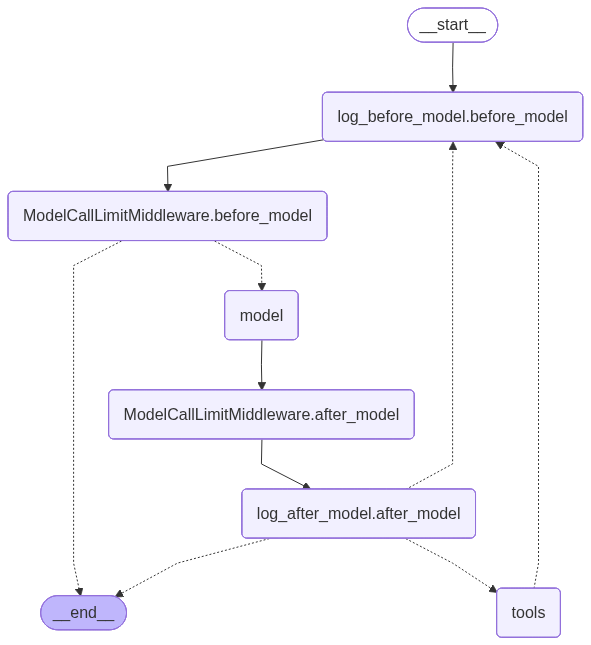

In [39]:
# Display the agent graph
try:
    from IPython.display import display, Image
    display(Image(wellness_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nAgent structure:")
    print(wellness_agent.get_graph().draw_ascii())

---
## ❓ Question #3:

How does **Agentic RAG** differ from traditional RAG? What are the advantages and potential disadvantages of letting the agent decide when to retrieve information?

##### ✅ Answer:
Traditional RAG follows a simple pattern - always retrieve from the knowledge base (vector database) and generate the output. AgenticRAG on the other hand uses RAG one of the tools and determines whether it needs to be used or not for a given query.

The advantage of letting the agent decide when to retrieve information is that for unrelated questions or questions that can be addressed by some other tools, no need to perform input query embedding and simialrity search, which is more efficient. 

The agent will loop through the reasoning steps and can retrieve from RAG multiple times as needed, whereas in traditional RAG, it's just a single retrieval.

The disadvantages include:
- The agent might mistakenly determine that RAG is not needed (hallucinate)
- if most queries benefit from leveraging RAG, the LLM reasoning required to make this decision involves additional latency and cost
- If the RAG tool description is not comprehensive, the agent might not know fully what is available in RAG, what is not.

## ❓ Question #4:

Looking at the middleware examples (`log_before_model`, `log_after_model`, and `ModelCallLimitMiddleware`), describe a real-world scenario where middleware would be essential for a production agent. What specific middleware hooks would you use and why?

##### ✅ Answer:
Detailed logging before and after model call, will enable troubleshooting; and to understand the agent's reasoning. The ModelCallLimitMiddleware is extremely useful to ensure the LLM bills don't escalate.

For example, in the case of a customer service agent, we can use ModelCallLimitMiddleware to redirect the customer if the issue is not resolved within a given number of model calls. This would provide a better experience for the customer rather than they getting frustrated with endless back and forth.

---
## 🏗️ Activity #2: Enhance the Agentic RAG System

Now it's your turn! Enhance the wellness agent by implementing ONE of the following:

### Option A: Add a New Tool
Create a new tool that the agent can use. Ideas:
- A tool that calculates BMI given height and weight
- A tool that estimates daily calorie needs
- A tool that creates a simple workout plan

### Option B: Create Custom Middleware
Build middleware that adds new functionality:
- Middleware that tracks which tools are used most frequently
- Middleware that adds a friendly greeting to responses
- Middleware that enforces a response length limit

### Option C: Improve the RAG Tool
Enhance the retrieval tool:
- Add metadata filtering
- Implement reranking of results
- Add source citations with relevance scores

In [ ]:
### YOUR CODE HERE ###

import random
import re

WELLNESS_QUOTES = ["He who has health has hope; and he who has hope, has everything. - Arabian Proverb.",
"Take care of your body. It's the only place you have to live. - Jim Rohn"
"So many people spend their health gaining wealth, and then have to spend their wealth to regain their health. - A.J. Reb Materi.",
"Nurturing yourself is not selfish; it's essential to your survival and your well-being. - Renee Peterson Trudeau",
"Wellness is the complete integration of body, mind, and spirit. - Greg Anderson."
] 

# A tool that calculates BMI
@tool
def calculate_bmi(height: float, weight: float) -> float:
   """Calculate the Body Mass Index (BMI) given a person's height and weight."""
   bmi = weight / (height ** 2)
   return bmi


@after_model
def add_wellness_quote(state, runtime):
   """Add a wellness quote to the finalresponse."""
   quote = "The only way to keep your health is to eat what you don't want, drink what you don't like, and do what you'd rather not."
   quote = random.choice(WELLNESS_QUOTES)
   last_message = state.get("messages", [])[-1] if state.get("messages") else None
   if last_message:
       has_tool_calls = hasattr(last_message, 'tool_calls') and last_message.tool_calls
       print(f"[LOG] After model - Tool calls requested: {has_tool_calls}")
       print(f"[DEBUG] tool_calls value: {getattr(last_message, 'tool_calls', 'NO ATTR')}")
       print(f"[DEBUG] has_tool_calls boolean: {bool(has_tool_calls)}")
       print(f"[DEBUG] not has_tool_calls: {not has_tool_calls}")  
       #check if the message has no tool calls append to the last message 
       if not has_tool_calls:
           print("[DEBUG] Entering quote addition block")
           print(f"[DEBUG] Content before quote: ...{last_message.content[-50:]}")
           last_message.content += "\n\n🌟 " + quote
           print(f"[DEBUG] Content after quote: ...{last_message.content[-50:]}")
   return state

@after_model
def limit_response_length(state, runtime):
   """Limit the response length to 200 words or less."""
   print("[DEBUG] limit_response_length running")
   last_message = state.get("messages", [])[-1] if state.get("messages") else None
   if last_message:
       has_tool_calls = hasattr(last_message, 'tool_calls') and last_message.tool_calls
       if not has_tool_calls:  # Only limit the final response
         matches = list(re.finditer(r'\S+', last_message.content))
         if len(matches) > 200:
            position_200 = matches[199].end()
            last_message.content = last_message.content[:position_200] + "..."
   return state


In [69]:
# Test your enhanced agent here
from langchain.agents import create_agent


# Reset the call counter
model_call_count = 0


# Define our tools - include the RAG tool and the calculator from earlier
rag_tools = [
   search_wellness_knowledge,
   calculate,
   get_current_time,
   calculate_bmi
]


# Create the agentic RAG system with middleware
wellness_agent_enhanced = create_agent(
   model="gpt-5",
   tools=rag_tools,
   system_prompt="""You are a helpful wellness assistant with access to a comprehensive health and wellness knowledge base.


Your role is to:
1. Answer questions about health, fitness, nutrition, sleep, and mental wellness
2. Always search the knowledge base when the user asks wellness-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be supportive and encouraging in your responses
5. If you cannot find relevant information, say so honestly


Remember: Always cite information from the knowledge base when applicable.""",
   middleware=[
       log_before_model,
       log_after_model,
       add_wellness_quote,
       limit_response_length,
       call_limiter
   ]
)


print("Wellness Agent enhanced with BMI tool and new middleware!")


Wellness Agent enhanced with BMI tool and new middleware!


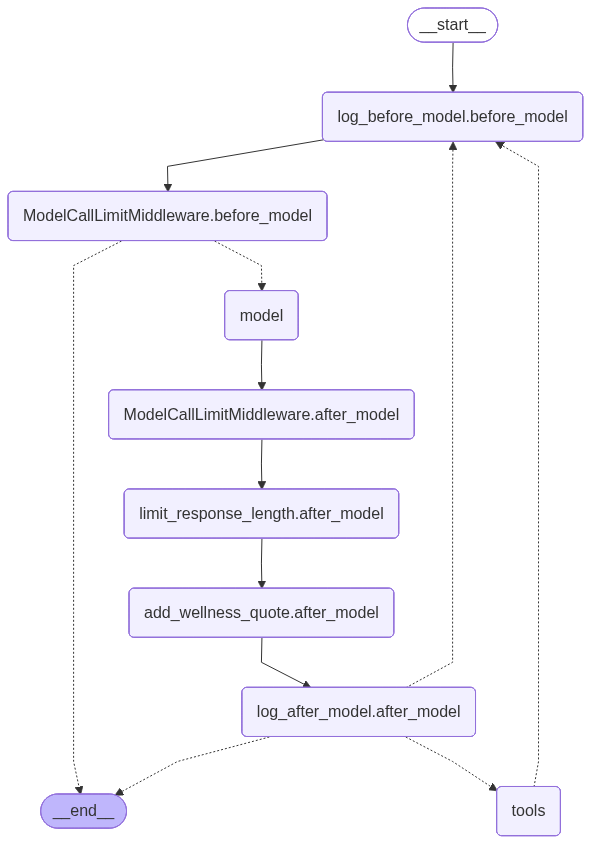

In [71]:
# Display the agent graph
try:
    from IPython.display import display, Image
    display(Image(wellness_agent_enhanced.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nAgent structure:")
    print(wellness_agent.get_graph().draw_ascii())

In [70]:
# Test your enhanced agent here
print("Testing the Enhanced Wellness Agent")
print("=" * 50)

response = wellness_agent_enhanced.invoke(
    {"messages": [{"role": "user", "content": "What are some ways to improve stamina?"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing the Enhanced Wellness Agent
[LOG] Model call #1 - Messages in state: 1
[DEBUG] limit_response_length running
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'ways to improve stamina endurance training tips increase aerobic capacity interval training progressive overload cross-training nutrition hydration sleep recovery mental strategies'}, 'id': 'call_0nKWXkSRGWmobHKZNEwTXz9Q', 'type': 'tool_call'}]
[DEBUG] tool_calls value: [{'name': 'search_wellness_knowledge', 'args': {'query': 'ways to improve stamina endurance training tips increase aerobic capacity interval training progressive overload cross-training nutrition hydration sleep recovery mental strategies'}, 'id': 'call_0nKWXkSRGWmobHKZNEwTXz9Q', 'type': 'tool_call'}]
[DEBUG] has_tool_calls boolean: True
[DEBUG] not has_tool_calls: False
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'ways to improve stamina endurance trai